In [181]:
%matplotlib inline

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Exam Preparation

In [183]:
EPSILON = 1e-6

In [184]:
spaceship_data = pd.read_csv("data/train.csv", true_values=["True"], false_values=["False"])

In [185]:
spaceship_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [186]:
spaceship_data.shape

(8693, 14)

In [187]:
spaceship_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [188]:
spaceship_data.CryoSleep.value_counts(dropna=False)

False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64

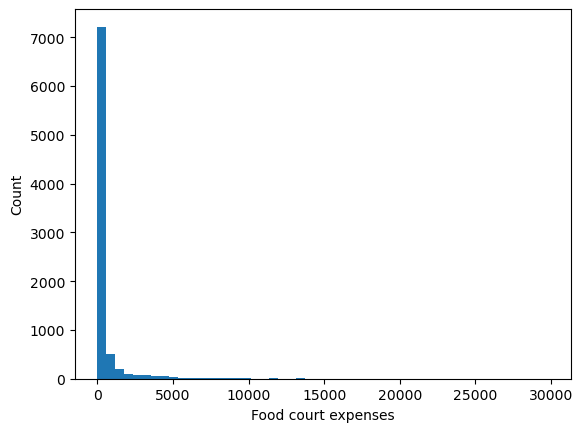

In [189]:
plt.hist(spaceship_data.FoodCourt, bins=50)
# plt.semilogx()
plt.xlabel("Food court expenses")
plt.ylabel("Count")
plt.show()

In [190]:
pd.qcut(spaceship_data.FoodCourt, q=20, duplicates = "drop").value_counts().sort_index()

(-0.001, 1.0]        5572
(1.0, 13.0]           395
(13.0, 76.0]          416
(76.0, 258.0]         426
(258.0, 608.0]        425
(608.0, 1026.0]       426
(1026.0, 2748.5]      424
(2748.5, 29813.0]     426
Name: FoodCourt, dtype: int64

In [191]:
spaceship_data[spaceship_data.FoodCourt == 0]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
12,0009_01,Mars,False,F/1/P,TRAPPIST-1e,32.0,False,73.0,0.0,1123.0,0.0,113.0,Berers Barne,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8681,9270_01,Earth,True,G/1497/S,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,Lan Mckinsond,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True
8685,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Polaton Conable,True
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False


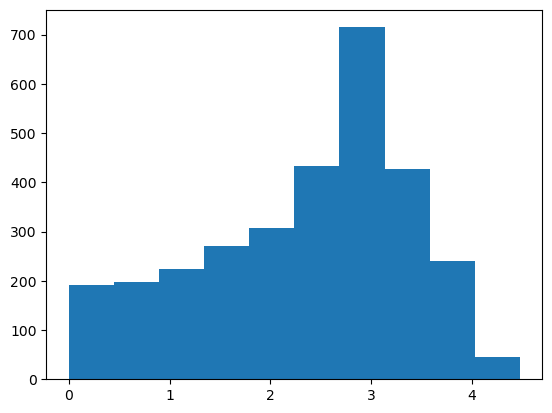

In [192]:
plt.hist(np.log10(spaceship_data.FoodCourt[spaceship_data.FoodCourt > 0]))
plt.show()

In [193]:
spaceship_data.loc[spaceship_data.FoodCourt <= 0, "FoodCourt"] = EPSILON

In [194]:
spaceship_data.FoodCourt = spaceship_data.FoodCourt.apply(lambda x: EPSILON if x <= 0 else x)

In [195]:
spaceship_data.FoodCourt.min()

1e-06

In [196]:
positive_values_transformer = FunctionTransformer(func=lambda x: np.array([EPSILON if elem <= 0 else elem for elem in x]))

In [197]:
positive_values_transformer.transform([1, 2, 3, 0, -5, -10])

array([1.e+00, 2.e+00, 3.e+00, 1.e-06, 1.e-06, 1.e-06])

In [198]:
log_transformer = FunctionTransformer(func=lambda x: np.log10(x))

In [199]:
pos_values = positive_values_transformer.transform([1, 2, 3, 0, -5, -10])
log_transformer.transform(pos_values)

array([ 0.        ,  0.30103   ,  0.47712125, -6.        , -6.        ,
       -6.        ])

In [200]:
log_pipeline = Pipeline([
    ("pos_values", positive_values_transformer),
    ("log10", log_transformer),
])

In [201]:
log_pipeline.transform([1, 2, 3, 0, -5, -10])

array([ 0.        ,  0.30103   ,  0.47712125, -6.        , -6.        ,
       -6.        ])

In [202]:
log_pipeline['pos_values']

FunctionTransformer(func=<function <lambda> at 0x151d876d0>)

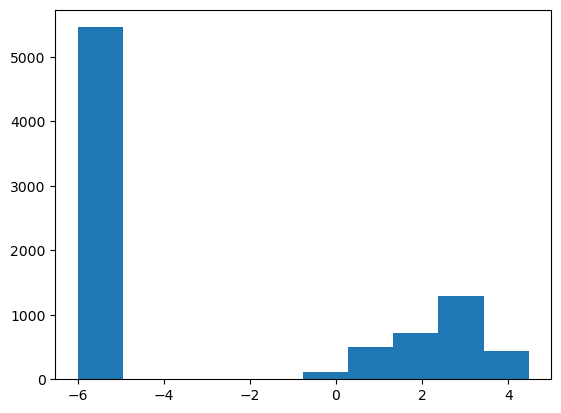

In [203]:
plt.hist(log_pipeline.transform(spaceship_data.FoodCourt))
plt.show()

In [204]:
spaceship_data.HomePlanet.value_counts(dropna=False)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64

In [205]:
pd.get_dummies(spaceship_data.HomePlanet, dummy_na=True, drop_first=True)

,Europa,Mars,NaN
0,1,0,0
1,0,0,0
2,1,0,0
3,1,0,0
4,0,0,0
...,...,...,...
8688,1,0,0
8689,0,0,0
8690,0,0,0
8691,1,0,0


In [206]:
spaceship_data.HomePlanet.fillna("Unknown").value_counts()

Earth      4602
Europa     2131
Mars       1759
Unknown     201
Name: HomePlanet, dtype: int64

In [207]:
ohe = OneHotEncoder()
ohe.fit(spaceship_data.HomePlanet.values.reshape(-1, 1))

OneHotEncoder()

In [208]:
ohe.categories_

[array(['Earth', 'Europa', 'Mars', nan], dtype=object)]

In [209]:
ohe.transform(spaceship_data.HomePlanet.values.reshape(-1, 1)).todense()

matrix([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [210]:
def fill_in_string_values(str_values):
    str_values = str_values.fillna("Unknown")
    str_values_column = str_values.values.reshape(-1, 1)
    return str_values_column

In [211]:
home_planet_pipeline = Pipeline(steps=[
    ("fill_na", FunctionTransformer(func=fill_in_string_values)),
    ("ohe", OneHotEncoder()),
    ("create_dense_matrix", FunctionTransformer(func=lambda x: np.array(x.todense())))
])

In [212]:
home_planet_pipeline.fit(spaceship_data.HomePlanet)

Pipeline(steps=[('fill_na',
                 FunctionTransformer(func=<function fill_in_string_values at 0x151e10dc0>)),
                ('ohe', OneHotEncoder()),
                ('create_dense_matrix',
                 FunctionTransformer(func=<function <lambda> at 0x151e10ca0>))])

In [213]:
transofmed_home_planets = home_planet_pipeline.transform(spaceship_data.HomePlanet)

In [214]:
pca = PCA(n_components=2)
pca.fit(transofmed_home_planets)

PCA(n_components=2)

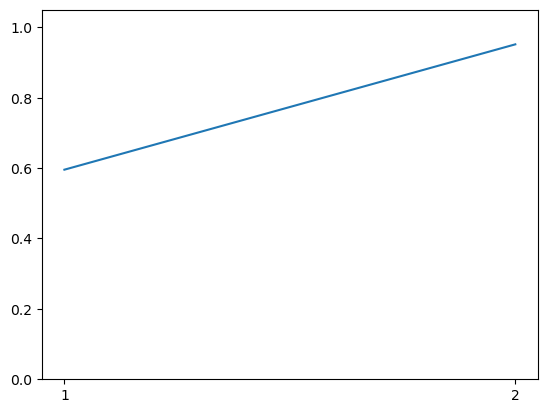

In [215]:
plt.plot(np.arange(1, len(pca.components_) + 1),np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0, 1.05)
plt.xticks(np.arange(1, len(pca.components_) + 1))
plt.show()

In [216]:
home_planet_pipeline = Pipeline(steps=[
    ("fill_na", FunctionTransformer(func=fill_in_planets)),
    ("ohe", OneHotEncoder()),
    ("create_dense_matrix", FunctionTransformer(func=lambda x: np.array(x.todense()))),
    ("pca", PCA(n_components=2))
])

In [217]:
home_planet_pipeline.fit(spaceship_data.HomePlanet)

Pipeline(steps=[('fill_na',
                 FunctionTransformer(func=<function fill_in_planets at 0x174a42290>)),
                ('ohe', OneHotEncoder()),
                ('create_dense_matrix',
                 FunctionTransformer(func=<function <lambda> at 0x151dfe7a0>)),
                ('pca', PCA(n_components=2))])

In [218]:
transofmed_home_planets = home_planet_pipeline.transform(spaceship_data.HomePlanet)

In [219]:
transofmed_home_planets

array([[ 0.74289896, -0.58169619],
       [-0.56620817, -0.04707087],
       [ 0.74289896, -0.58169619],
       ...,
       [-0.56620817, -0.04707087],
       [ 0.74289896, -0.58169619],
       [ 0.74289896, -0.58169619]])

In [220]:
search = GridSearchCV(home_planet_pipeline, param_grid={
    "pca__n_components": [1, 2, 3, 4],
    # "home_planet__pca__n_components": [1, 2, 3, 4],
})

In [221]:
search.fit(spaceship_data.HomePlanet)

/Users/ivelin.borisov/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-1.45097405 -0.2199532         -inf        -inf]
  warnings.warn(
/Users/ivelin.borisov/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


GridSearchCV(estimator=Pipeline(steps=[('fill_na',
                                        FunctionTransformer(func=<function fill_in_planets at 0x174a42290>)),
                                       ('ohe', OneHotEncoder()),
                                       ('create_dense_matrix',
                                        FunctionTransformer(func=<function <lambda> at 0x151dfe7a0>)),
                                       ('pca', PCA(n_components=2))]),
             param_grid={'pca__n_components': [1, 2, 3, 4]})

In [222]:
search.cv_results_

{'mean_fit_time': array([0.04140644, 0.02854977, 0.01391125, 0.00625215]),
 'std_fit_time': array([0.02248464, 0.01723245, 0.00890104, 0.00337525]),
 'mean_score_time': array([0.00243959, 0.00069618, 0.00115356, 0.001405  ]),
 'std_score_time': array([0.00318918, 0.00011579, 0.00070429, 0.00120707]),
 'param_pca__n_components': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 1},
  {'pca__n_components': 2},
  {'pca__n_components': 3},
  {'pca__n_components': 4}],
 'split0_test_score': array([-1.42556499, -0.13879519,        -inf, 17.64074936]),
 'split1_test_score': array([-1.45059461, -0.25972173,        -inf, 21.43180679]),
 'split2_test_score': array([-1.53664913, -0.24710998,        -inf, 17.41252582]),
 'split3_test_score': array([-1.42801955, -0.25251356,        -inf, 17.55025621]),
 'split4_test_score': array([-1.41404198, -0.20162552, 13.44677829,        -inf]),

In [223]:
search.best_params_

{'pca__n_components': 2}

In [224]:
home_planet_pipeline

Pipeline(steps=[('fill_na',
                 FunctionTransformer(func=<function fill_in_planets at 0x174a42290>)),
                ('ohe', OneHotEncoder()),
                ('create_dense_matrix',
                 FunctionTransformer(func=<function <lambda> at 0x151dfe7a0>)),
                ('pca', PCA(n_components=2))])

(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

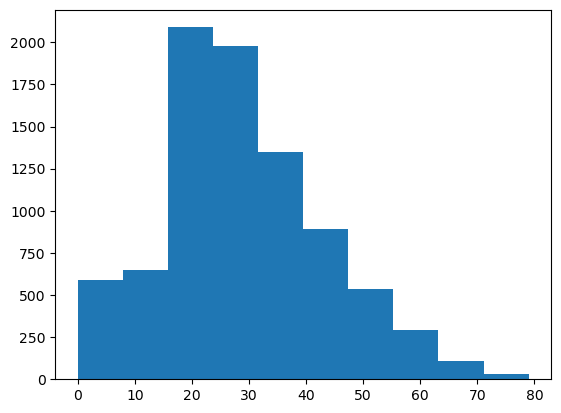

In [225]:
plt.hist(spaceship_data.Age)

In [226]:
log_pipeline

Pipeline(steps=[('pos_values',
                 FunctionTransformer(func=<function <lambda> at 0x151d876d0>)),
                ('log10',
                 FunctionTransformer(func=<function <lambda> at 0x151d84940>))])

In [227]:
spaceship_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [228]:
FeatureUnion([
    ("log_of_price", log_pipeline),
    ("planet_encoding", home_planet_pipeline)
])

FeatureUnion(transformer_list=[('log_of_price',
                                Pipeline(steps=[('pos_values',
                                                 FunctionTransformer(func=<function <lambda> at 0x151d876d0>)),
                                                ('log10',
                                                 FunctionTransformer(func=<function <lambda> at 0x151d84940>))])),
                               ('planet_encoding',
                                Pipeline(steps=[('fill_na',
                                                 FunctionTransformer(func=<function fill_in_planets at 0x174a42290>)),
                                                ('ohe', OneHotEncoder()),
                                                ('create_dense_matrix',
                                                 FunctionTransformer(func=<function <lambda> at 0x151dfe7a0>)),
                                                ('pca',
                                                 PCA(n_components=2))]))])

In [229]:
ColumnTransformer([
    ("log_of_price", log_pipeline, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]),
    ("planet_encoding", home_planet_pipeline, ["HomePlanet"]),
])

ColumnTransformer(transformers=[('log_of_price',
                                 Pipeline(steps=[('pos_values',
                                                  FunctionTransformer(func=<function <lambda> at 0x151d876d0>)),
                                                 ('log10',
                                                  FunctionTransformer(func=<function <lambda> at 0x151d84940>))]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck']),
                                ('planet_encoding',
                                 Pipeline(steps=[('fill_na',
                                                  FunctionTransformer(func=<function fill_in_planets at 0x174a42290>)),
                                                 ('ohe', OneHotEncoder()),
                                                 ('create_dense_matrix',
                                                  FunctionTransformer(func=<function <lambda> at 0x151dfe7a0>)),
                                                 ('pca', PCA(n_components=2))]),
                                 ['HomePlanet'])])

In [230]:
tfidf = TfidfVectorizer()
tfidf.fit(spaceship_data.Name.fillna("None"))

TfidfVectorizer()

In [231]:
tfidf.transform(spaceship_data.Name.fillna("None"))

<8693x4891 sparse matrix of type '<class 'numpy.float64'>'
	with 17186 stored elements in Compressed Sparse Row format>

In [232]:
names_encoding_pipeline = Pipeline([
    ("fill_na", FunctionTransformer(fill_in_string_values)),
    ("tfidf", TfidfVectorizer()),
    ("svd", TruncatedSVD())
])

In [233]:
names_encoding_pipeline

Pipeline(steps=[('fill_na',
                 FunctionTransformer(func=<function fill_in_string_values at 0x151e10dc0>)),
                ('tfidf', TfidfVectorizer()), ('svd', TruncatedSVD())])

In [234]:
column_transformer = ColumnTransformer([
    ("log_of_price", log_pipeline, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]),
    ("planet_encoding", home_planet_pipeline, ["HomePlanet"]),
    ("names_encoding", names_encoding_pipeline, ["Name"]),
])

In [235]:
pipeline = Pipeline([
    ("features", column_transformer),
    ("final_pca", PCA()),
    ("model", LogisticRegression()),
])

In [236]:
pipeline.steps

[('features',
  ColumnTransformer(transformers=[('log_of_price',
                                   Pipeline(steps=[('pos_values',
                                                    FunctionTransformer(func=<function <lambda> at 0x151d876d0>)),
                                                   ('log10',
                                                    FunctionTransformer(func=<function <lambda> at 0x151d84940>))]),
                                   ['RoomService', 'FoodCourt', 'ShoppingMall',
                                    'Spa', 'VRDeck']),
                                  ('planet_encoding',
                                   Pipeline(steps=[('fill_na',
                                                    FunctionTransformer(func=<function fill...at 0x174a42290>)),
                                                   ('ohe', OneHotEncoder()),
                                                   ('create_dense_matrix',
                                                    Functio

In [237]:
"features__names_encoding__tfidf__min_df"

'features__names_encoding__tfidf__min_df'

In [238]:
search = GridSearchCV(pipeline, param_grid={})
search.fit()

search.best_estimator_

TypeError: BaseSearchCV.fit() missing 1 required positional argument: 'X'

In [254]:
for group_index, group_data in spaceship_data.groupby(["Transported", pd.qcut(spaceship_data.Age, 5)]):
    print(group_index)
    # break

(False, Interval(-0.001, 18.0, closed='right'))
(False, Interval(18.0, 24.0, closed='right'))
(False, Interval(24.0, 31.0, closed='right'))
(False, Interval(31.0, 41.0, closed='right'))
(False, Interval(41.0, 79.0, closed='right'))
(True, Interval(-0.001, 18.0, closed='right'))
(True, Interval(18.0, 24.0, closed='right'))
(True, Interval(24.0, 31.0, closed='right'))
(True, Interval(31.0, 41.0, closed='right'))
(True, Interval(41.0, 79.0, closed='right'))


In [252]:
pd.qcut(spaceship_data.Age, 5)

0         (31.0, 41.0]
1         (18.0, 24.0]
2         (41.0, 79.0]
3         (31.0, 41.0]
4       (-0.001, 18.0]
             ...      
8688      (31.0, 41.0]
8689    (-0.001, 18.0]
8690      (24.0, 31.0]
8691      (31.0, 41.0]
8692      (41.0, 79.0]
Name: Age, Length: 8693, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 18.0] < (18.0, 24.0] < (24.0, 31.0] < (31.0, 41.0] < (41.0, 79.0]]